---
title:  "keras를 이용한 시계열 분석 LSTM 활용"
excerpt: "Keras를 사용한 시계열 분석"

categories:
  - Machine-Learning
tags:
  - Keras
  - Time Series Analysis
  - LSTM  
  - Advanced Keras
last_modified_at: 2020-04-01T16:13:00-05:00
---

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Keras를 활용한 시계열 분석

## 케라스 고급사용법
- recurrent dropout : 순환층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드랍아웃기능
- stacking recurrent layer : 네트워크의 표현 능력을 증가시킴
- bidirectional recurrent layer : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킨다.

### 기온예측 데이터 불러오기  
 이 시계열 데이터는 건물 옥상에 설치된 센서에서 취득한 온도, 기압, 습도 같은 데이터입니다. 이 데이터를 사용하여 마지막 데이터 포인트에서부터 24시간 이후의 온도를 예측하겠습니다.  
 이 데이터셋에는 수년간에 걸쳐 (기온, 기압, 습도, 풍향 등과 같은) 14개의 관측치가 10분마다 기록되어 있습니다. 원본 데이터는 2003년부터 기록되어 있지만 이 예제에서는 2009~2016년 사이의 데이터만 사용합니다. 이 데이터셋은 시계열 수치 데이터를 다루는 법을 익히는 데 안성맞춤입니다. 최근 데이터(몇 일치 데이터 포인트)를 입력으로 사용해 모델을 만들고 24시간 이후의 기온을 예측하겠습니다.

In [2]:
import os

data_dir = 'D:/★2020_ML_DL_Project/Alchemy/dataset/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [3]:
fname

'D:/★2020_ML_DL_Project/Alchemy/dataset/jena_climate\\jena_climate_2009_2016.csv'

In [4]:
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [5]:
print(len(header))

15


In [6]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1)) #  len(header) - 1 = 14임. 
print("float_data_shape {}".format(float_data.shape))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] # Date Time 은 제외하고, 값에 넣고 있음.
    float_data[i, :] = values

float_data_shape (420551, 14)


In [7]:
print("ndim:{}".format(float_data.ndim),"   shape:{}".format(float_data.shape))

ndim:2    shape:(420551, 14)


In [8]:
np.set_printoptions(precision=6)
float_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

In [9]:
lines[0] ## 의도적으로 Datatime 은 float_data 셋에서, 컬럼화되지 않았음을 알 수 있다.

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

예를 들어 다음은 시간에 따른 기온(섭씨) 그래프입니다:

In [10]:
from matplotlib import pyplot as plt

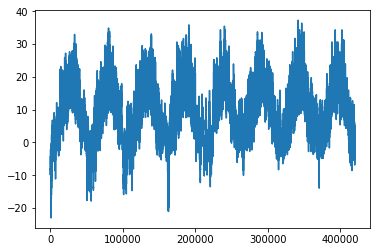

In [11]:
temp = float_data[:, 1]  # 온도(섭씨) "T (degC)"
plt.plot(range(len(temp)), temp)
plt.show()

이 그래프에서 온도에 주기성이 있다는 것을 잘 볼 수 있습니다.

다음은 기간을 좁혀서 처음 10일간의 온도 데이터를 나타낸 그래프입니다. 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있습니다:

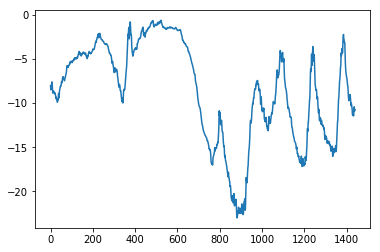

In [12]:
plt.plot(range(1440), temp[:1440])
plt.show()

### 필자는 pandas 가 익숙해서 바꾼다. 

In [13]:
header_pd = list(map(lambda x : x.replace('"','').replace(' ','').upper(),header[1:]) )
print(header_pd)

['P(MBAR)', 'T(DEGC)', 'TPOT(K)', 'TDEW(DEGC)', 'RH(%)', 'VPMAX(MBAR)', 'VPACT(MBAR)', 'VPDEF(MBAR)', 'SH(G/KG)', 'H2OC(MMOL/MOL)', 'RHO(G/M**3)', 'WV(M/S)', 'MAX.WV(M/S)', 'WD(DEG)']


In [14]:
import pandas as pd
float_df = pd.DataFrame(float_data,columns = header_pd)
print(float_df.shape,"float_data.shape:{}".format(float_data.shape))

(420551, 14) float_data.shape:(420551, 14)


In [15]:
float_df.head(3)

,P(MBAR),T(DEGC),TPOT(K),TDEW(DEGC),RH(%),VPMAX(MBAR),VPACT(MBAR),VPDEF(MBAR),SH(G/KG),H2OC(MMOL/MOL),RHO(G/M**3),WV(M/S),MAX.WV(M/S),WD(DEG)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


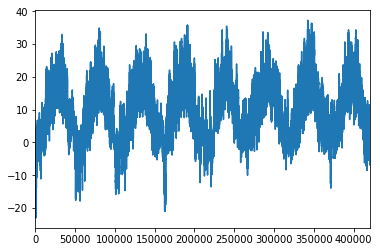

In [16]:
float_df["T(DEGC)"].plot(kind='line') ## 이렇게 해도 위에와 똑같다.

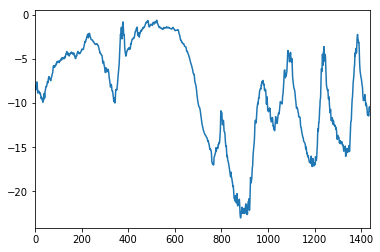

In [17]:
float_df["T(DEGC)"].iloc[:1440].plot(kind='line') ##  기간을 좁혀서 다시 표현한다.

In [18]:
print(60*24) ## 1일치를 분으로 환산한 값
## 본 예제에서는 10분다 1개의 row 이므로, 
print(60*24/10) ## 즉 144 row (행) 이 1일치이고, 6row(행) 이 1 hour 이다.

1440
144.0


## Preparing the data & 1일후 하루 후 값을 예측해보기

* `lookback = 1440` : 1440 을 넣으면, 10일 전 데이터로 돌아간다는 의미로 설정하는 것
* `steps = 6` : 6이란 값을 넣으면, 한 시간마다 데이터 포인트 하나를 샘플링한다는 뜻.
* `delay = 144` : 144 값을 넣으면, 24시간이 지난 데이터가 타깃이 된다는 뜻

#### 데이터 전처리
* 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다. 데이터가 이미 수치형이므로 추가적인 벡터화가 필요하지 않습니다. 하지만 데이터에 있는 각 시계열 특성의 범위가 서로 다릅니다(예를 들어 온도는 일반적으로 -20도에서 +30도 사이이고, 밀리바(mb)로 측정된 기압은 1,000 근처의 값). 각 시계열 특성을 개별적으로 정규화한다.
* float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듭니다. 이 데이터셋에 있는 샘플은 중복이 많습니다(샘플 `N`과 샘플 `N + 1`은 대부분 타임스텝이 비슷합니다). 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용해 그때 그때 배치를 만들겠습니다.

각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리합니다. 처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산합니다:

In [19]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

다음은 여기서 사용할 제너레이터입니다. 이 제너레이터 함수는 `(samples, targets)` 튜플을 반복적으로 반환합니다. `samples`는 입력 데이터로 사용할 배치이고 `targets`은 이에 대응되는 타깃 온도의 배열입니다. 이 제너레이터 함수는 다음과 같은 매개변수가 있습니다:

* `data` : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.

In [20]:
np.random.randint(0,10,3) ## 함수 확인용으로 test

array([5, 5, 2])

In [21]:
np.arange(10,20) ## 함수 확인용으로 test

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [63]:
for i in range(1,10,2): ## 함수 확인용으로 test
    print(i)

1
3
5
7
9


* generator 막간 설명 참조 (https://bluese05.tistory.com/56)

In [80]:
def generator_test(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1 ## 추출한 타임의 max 범위를 지정하지 않으면, 전체데이터에서, delay 부분을 빼고, -1 한 부분까지가 max_index로 지정된다.
                                          ## 즉 validatin set 이 없어진다는 의미로, 이해하면 된다.
    i = min_index + lookback # 데이터 시작 time_stamp 에서, lookback 값을 더한다.
    print("i(min_index + lookback)의미 :{}".format(i))
    while 1: # 무조건 while 문을 실행하기 위함
        print("While loop start")
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback # 데이터 시작 time_stamp 에서, lookback 값을 더한다. 왜 if 문에 넣었는지는 모름
            print("i {}".format(i))
            ## i 는 결국 시작 time_stamp 가 된다.
            rows = np.arange(i, min(i + batch_size, max_index)) # arange 객체생성. 추출할 데이터 목적(train,val,test) 에 맞춰 활용할 row 를 batch_sizedhk max_index 를 고려해서 뽑아낸다
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step, ## 나누기의 몫 을 return 함. "lookback // step" 은 보고자 하는 값들을 시간 단위로 쪼개갰다는 의미이다. step=6 이 결국 10분 * 6 = 1시간
                           data.shape[-1])) # data의 마지막 차원을 불러온다. 3d tensor 로 보여줌
        print("samples.shape:{}".format(samples.shape))
        targets = np.zeros((len(rows),))
        
        print("data.shape:{}".format(data.shape))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step) # rows[j]에 해당하는 index 값-과거 10일전 => 즉 해당 index 데이터의 10일전 과거 ~ 해당 index 까지의 data , step:1시간단위
            ## 결론:해당 j 포인트 데이터의 과거 10 일치 데이터를 1시간 단위 값들만 추려서 indices 를 만든다.
            samples[j] = data[indices] ## 그 값을 samples[j] 번째에, 2D tensor로 넣고
            targets[j] = data[rows[j] + delay][1] ## 타겟값을 만든다, 해당 j 포이트 데이터의 24시간 이후의 데이터의 [1] 에 해당하는 값 => 온도 임.
#         yield samples, targets
        print("samples[10]",samples[10],"shape:{}".format(samples[10].shape))
        print("targets[10]",targets[10])
        return samples, targets       

In [81]:
print(float_data.shape)
float_data.shape[0]//(6*24) ## 현재 2920 일치에 해당하는 데이터를 가지고 있다.

(420551, 14)


2920

#### generator_test 로 어떤 값들이 yield 될지 유추해본다.

In [82]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

t_sample,t_targets = generator_test(float_data, # 변환코자 하는 data 삽입
                      lookback=lookback, # 10일전 데이터로 돌아간다.
                      delay=delay,# 144 값을 넣으면, 24시간이 지난 데이터가 타깃이 된다는 뜻
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

i(min_index + lookback)의미 :1440
While loop start
samples.shape:(128, 240, 14)
data.shape:(420551, 14)
samples[10] [[ 0.305838  0.177651  0.152312 ...  0.910411  0.721032 -1.631703]
 [ 0.302301  0.234132  0.208158 ...  0.786767  0.669545 -1.679386]
 [ 0.307017  0.257854  0.231613 ...  0.37028   0.399237 -1.667263]
 ...
 [ 0.808171  0.585445  0.516426 ... -1.308681 -1.317006 -0.278445]
 [ 0.908402  0.664519  0.586792 ... -1.263128 -1.046697  1.244417]
 [ 0.928448  0.60126   0.523127 ... -0.638398 -0.617637 -1.955672]] shape:(240, 14)
targets[10] 0.1708727711749447


1. 우선 i 값에 1440 번째 시작 timestamp 를 찍는다
2. rows = np.random.randint(min_index + lookback, max_index, size=batch_size) => shuffle 실행(1440,200000,128 만큼의 배치사이즈만큼 골라낸다.)  
> 이때 rows 의 len 은 128 이다.
> 들어온 데이터에서, 128 개 row 를 1440~200000 만 사이에서 골라냈다. 
3. samples 는 우선 zero 행렬로 (128, 1440//6 [10일 데이터를 1시간 단위로 쪼갠다는 의미], data.shape[-1] = 14) 3d tensor 형태를 만든다.
> 

In [31]:
t_sample.shape

(128, 240, 14)

In [33]:
t_targets.shape

(128,)

이제 generator 함수를 사용해 훈련용, 검증용, 테스트용으로 세 개의 제너레이터를 만들어 보죠. 각 제너레이터는 원본 데이터에서 다른 시간대를 사용합니다. 훈련 제너레이터는 처음 200,000개 타임스텝을 사용하고 검증 제너레이터는 그 다음 100,000개를 사용하고 테스트 제너레이터는 나머지를 사용합니다.

In [83]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [84]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, # 변환코자 하는 data 삽입
                      lookback=lookback, # 10일전 데이터로 돌아간다.
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

In [85]:
train_gen

<generator object generator at 0x00000125C3B05318>

In [86]:
dir(train_gen)

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__next__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'gi_code',
 'gi_frame',
 'gi_running',
 'gi_yieldfrom',
 'send',
 'throw']

`train_gen` 객체는 generator 라고 뜨는 것을 볼수 있다. 더욱이 dir(train_gen) 로 보면, `__iter__` , `__next__` 가 있어서, generator 객체로 변환되었음을 보게된다.

In [87]:
train_gen.__next__()

(array([[[ 0.515733, -0.067478, -0.106812, ..., -0.169851, -0.081311,
           0.840322],
         [ 0.624218,  0.094058,  0.043971, ..., -1.002824, -0.832167,
          -0.754123],
         [ 0.643085,  0.26915 ,  0.215976, ..., -0.410632, -0.403106,
          -0.183771],
         ...,
         [ 0.266925,  0.127947,  0.105402, ..., -0.976793, -1.046697,
          -1.572358],
         [ 0.2457  ,  0.17991 ,  0.159014, ..., -1.289158, -1.261228,
          -0.847642],
         [ 0.274   ,  0.146021,  0.123272, ..., -1.23059 , -1.20974 ,
           0.181069]],
 
        [[ 0.887176,  0.167484,  0.096466, ...,  0.409326,  0.506502,
          -1.628816],
         [ 0.790483,  0.552686,  0.485152, ..., -0.215404, -0.188576,
          -1.135127],
         [ 0.717374,  0.655482,  0.593493, ...,  1.099131,  1.098606,
          -1.410258],
         ...,
         [ 0.865951, -0.183829, -0.249777, ...,  0.448371,  0.399237,
           0.891122],
         [ 0.883639, -0.068608, -0.136969, ..., -

In [88]:
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

* train_gen 살펴보기

float_data.shape = (420551, 14) 에서, generator 를 통과시키면,

In [ ]:
float_data.shape

In [ ]:
# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size